In [1]:
import os
import tensorflow as tf
import cProfile

In [2]:
tf.__version__

'2.6.0'

In [3]:
tf.executing_eagerly()

True

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [5]:
np.__version__

'1.21.3'

In [6]:
matplotlib.__version__

'3.4.1'

In [7]:
array = np.array([1,2,3,4])
tf.constant(array)

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([1, 2, 3, 4])>

In [8]:
a = tf.constant([[1, 2],
                 [3, 4]])
print(a)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


In [9]:
a.numpy()

array([[1, 2],
       [3, 4]])

In [10]:
# Broadcasting support
b = tf.add(a, 1)
print(b)

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


In [11]:
print(a * b)

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


In [12]:
np.multiply(a, b)

array([[ 2,  6],
       [12, 20]])

In [13]:
def fizzbuzz(max_num):
  counter = tf.constant(0)
  max_num = tf.convert_to_tensor(max_num)
  for num in range(1, max_num.numpy()+1):
    num = tf.constant(num)
    if int(num % 3) == 0 and int(num % 5) == 0:
      print('FizzBuzz')
    elif int(num % 3) == 0:
      print('Fizz')
    elif int(num % 5) == 0:
      print('Buzz')
    else:
      print(num.numpy())
    counter += 1

In [14]:
fizzbuzz(15)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz


In [15]:
x = tf.constant(3.0)
with tf.GradientTape() as g:
  g.watch(x)
  y = x * x # y = x^2
dy_dx = g.gradient(y, x) # dy_dx = 2x -> 2(3) = 6
print(dy_dx)

tf.Tensor(6.0, shape=(), dtype=float32)


In [16]:
x = tf.constant(5.0)
with tf.GradientTape() as g:
  g.watch(x)
  with tf.GradientTape() as gg:
    gg.watch(x)
    y = x * x # y = x^2
  dy_dx = gg.gradient(y, x)  # dy_dx = 2 * x
d2y_dx2 = g.gradient(dy_dx, x)  # d2y_dx2 = 2
print(dy_dx)

print(d2y_dx2)

tf.Tensor(10.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)


In [17]:
# Fetch and format the mnist data
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

[]

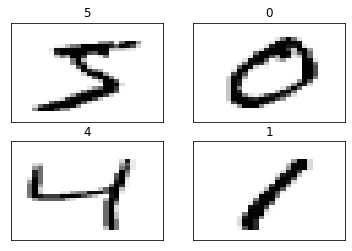

In [18]:
fig, axes = plt.subplots(2, 2)
for i in range(4):
    x, y = i//2, i % 2
    axes[x,y].pcolormesh(mnist_images[i][::-1], vmin=0, vmax=255, cmap='Greys')
    axes[x,y].set_title(mnist_labels[i])
    axes[x,y].set_xticks([])
    axes[x,y].set_yticks([])
plt.plot()

In [19]:
# Build the model
mnist_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu',
                         input_shape=(None, None, 1)),
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])

In [20]:
for images,labels in dataset.take(1):
  print("Logits: ", mnist_model(images[0:1]).numpy())

Logits:  [[ 0.01428761  0.04430338  0.02672514  0.0439501   0.01259952  0.00081331
   0.02448438  0.0333115   0.01189561 -0.0340645 ]]


In [21]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

In [22]:
def train_step(images, labels):
  with tf.GradientTape() as tape:
    logits = mnist_model(images, training=True)

    # Add asserts to check the shape of the output.
    tf.debugging.assert_equal(logits.shape, (32, 10))

    loss_value = loss_object(labels, logits)

  loss_history.append(loss_value.numpy().mean())
  grads = tape.gradient(loss_value, mnist_model.trainable_variables)
  optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [23]:
def train(epochs):
  for epoch in range(epochs):
    for (batch, (images, labels)) in enumerate(dataset):
      train_step(images, labels)
    print ('Epoch {} finished'.format(epoch))

In [24]:
train(epochs = 3)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished


Text(0, 0.5, 'Loss [entropy]')

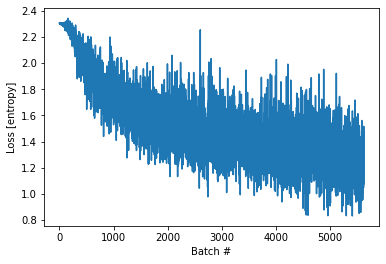

In [25]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')